# Token Frequency and Learning Signal Precision

Ailem et al. (2021) introduced WCE with the aim of sending stronger learning signals to their models when terminology is encountered. However, not all tokens which comprise terminology are exclusive to it. The degree to which these tokens are restricted to terminology determines the precision of these learning signals - to what extent are you penalising a model more heavily when it fails to predict a token when it is part of terminology? 

Furthermore, are some tokens more likely to appear in a terminological context than others? Intuitively, if a very common token appears in terminology, it may also be part of many other non-(biomedical) terminology. E.g., "Law" in "Starling's Law".

This data analysis seeks to measure the correlation between token frequency in the training set and learning signal precision.

In [1]:
#We've word-tokenised the whole FR side of the training set using Stanza's sequoia-trained FR tokeniser, and obtained counts of each word.
import pandas as pd
input = open("train_word_frequencies.txt", "r", encoding="utf8")
words = []
counts = []
for line in input.readlines():
    line_list = line.strip().split("\t")
    words.append(line_list[0])
    counts.append(int(line_list[1]))
input.close()
train_words = pd.DataFrame(data = {"word":words, "count":counts}) #We could not use pandas' read_csv due to " being a token.

In [2]:
gloss_base_freq = pd.read_csv("gloss_base_freq.txt", sep = "\t", header = None, names = ["token", "frequency"])
gloss_big_freq = pd.read_csv("gloss_big_freq.txt", sep = "\t", header = None, names = ["token", "frequency"])

In [3]:
#We will use the results from get_gloss_token_freq_in_train.py, which computes the training-set frequencies of all tokens generated from the entire glossary, for both opus-base and opus-big tokenizers.
#We will also load in our full training set-sampled glossary - we know that these words occurred at least once in our training set. 
from datasets import load_dataset, Dataset
#Converts data in src [TAB] tgt [NEWLINE] format to a format suitable for model training
def convertToDictFormat(data):
    source = []
    target = []
    for example in data:
        example = example.strip()
        sentences = example.split("\t")
        source.append(sentences[0])
        target.append(sentences[1])
    ready = Dataset.from_dict({"en":source, "fr":target})
    return ready

In [4]:
terms_in_train = load_dataset("ethansimrm/sampled_glossary_1.0_train", split = "train")
terms_in_train_ready = convertToDictFormat(terms_in_train['text'])

Found cached dataset text (C:/Users/ethan/.cache/huggingface/datasets/ethansimrm___text/ethansimrm--sampled_glossary_1.0_train-2f618074f2b08fee/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


## Strategy
- Decompose each training set FR word into subword tokens using opus-big and opus-base.
- Suppose word ABC --> "A", "B", "C" and count = Q, thus each of "A", "B", "C" have count = Q as well. 
- Our dataframe will look like: 
- - Word Token Count
- - ABC A Q
- - ABC B Q
- And so on. 
- We first filter the tokens which we know arise from the entire glossary (get_train_token_freq.py). This same script also provides us with per-token training set frequencies, using the same method we apply in the adaptive WCE implementation.
- For each token, we estimate the probability of it possessing a terminological parent word, using our 1.0-sampled glossary list as a source of terminology. This estimates the precision of the learning signal.
- Finally, perform an appropriate statistical test to determine the strength of the association between frequency and learning set precision.

In [5]:
from transformers import AutoTokenizer
base_tok = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
big_tok = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-tc-big-en-fr")

In [6]:
#Don't count these special tokens in the training set (not organic)
SPECIAL_BASE_TOKENS = [0, 1, 59513]
SPECIAL_BIG_TOKENS = [43311, 50387, 43312, 53016]

In [7]:
#Settle base tokenisation first and obtain parent words per token, along with counts
token_list = []
parent_word = []
counts = []
for row in train_words.itertuples():
    token_ids = base_tok(text_target=row.word)["input_ids"]
    for id in token_ids:
        if (id not in SPECIAL_BASE_TOKENS):
            token_list.append(id)
            parent_word.append(row.word)
            counts.append(row.count)
train_base_tokens = pd.DataFrame(data = {"token":token_list, "parent_word":parent_word, "count":counts})

In [8]:
#Filter only tokens from our base-tokenised glossary
train_base_tokens_gloss_only = train_base_tokens[train_base_tokens["token"].isin(gloss_base_freq["token"])].sort_values("token").reset_index(drop=True)

In [9]:
#Find total count of each token in the training set, per our word tokeniser
train_base_tokens_gloss_only_counts = train_base_tokens_gloss_only.drop(columns=["parent_word"]).groupby(["token"]).sum().reset_index()
train_base_tokens_gloss_only_counts = train_base_tokens_gloss_only_counts.rename(columns={"count":"total_count"}) 

In [10]:
train_base_tokens_gloss_only_counts

,token,total_count
0,3,36170
1,4,585
2,5,1011354
3,6,389053
4,7,612
...,...,...
5228,48333,201
5229,48348,16
5230,48383,76
5231,48715,2


In [11]:
#Find total count of each token arising from a terminological parent word. This is case-sensitive, because the tokenizer is also case-sensitive.
train_base_tokens_parents_sampled_gloss_only = train_base_tokens[train_base_tokens["parent_word"].isin(terms_in_train_ready["fr"])].drop(columns="parent_word").groupby(["token"]).sum().reset_index()
train_base_tokens_parents_sampled_gloss_only = train_base_tokens_parents_sampled_gloss_only.rename(columns = {"count":"term_count"})

In [12]:
train_base_tokens_parents_sampled_gloss_only

,token,term_count
0,5,715
1,8,49
2,9,15099
3,10,98
4,11,60
...,...,...
1690,47745,154
1691,48007,9
1692,48130,488
1693,48162,1


In [13]:
#Of course, we don't know what terminology there is in the training set, but the learning signals are applied specifically to our terminology set anyway. We can now compute precision.
base_tok_precision_df = train_base_tokens_parents_sampled_gloss_only.merge(train_base_tokens_gloss_only_counts, how="inner", on="token")
base_tok_precision_df["learning_signal_precision"] = base_tok_precision_df["term_count"] / base_tok_precision_df["total_count"] 
base_tok_precision_df_compact = base_tok_precision_df.drop(columns = ["term_count", "total_count"])

In [14]:
#We will now join the LSP and training set frequency dataframes, and replace all NaNs with 0.
base_freq_lsp = gloss_base_freq.merge(base_tok_precision_df_compact, how="left", on="token").sort_values("token").reset_index(drop=True)

In [15]:
#Chop off tokens which do not occur in the training set at all
base_freq_lsp = base_freq_lsp[base_freq_lsp["frequency"] > 0]

In [16]:
#We will drop NaNs - we cannot say anything about tokens we didn't pick up when we queried the training set for glossary words.
#This is because we do not know what terminology is in the training set, and it is infeasible to perform a search (just 588 test set sentences took 30 minutes to annotate via NCBO)
base_freq_lsp_dropped_nas = base_freq_lsp.dropna().sort_values("frequency", ascending=False).reset_index(drop=True)

In [17]:
import numpy as np
base_freq_lsp_dropped_nas["log_freq"] = np.log(base_freq_lsp_dropped_nas["frequency"])
base_freq_lsp_dropped_nas["log_lsp"] = np.log(base_freq_lsp_dropped_nas["learning_signal_precision"] + 1) #Add-one smoothing as LSP can be 0

<Axes: title={'center': 'Log-log plot of LSP against token frequency for opus-base'}, xlabel='Log Token Frequency', ylabel='Log (LSP + 1)'>

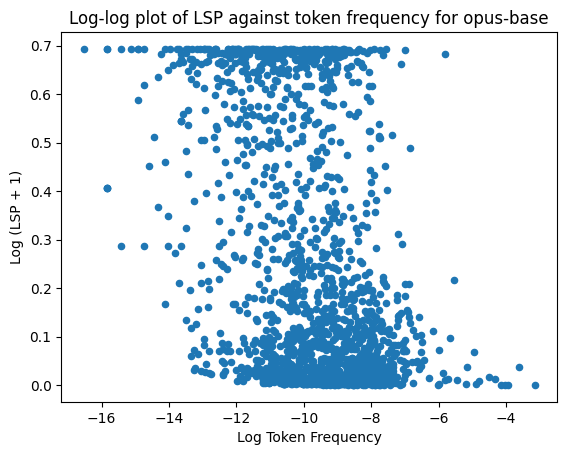

In [46]:
#Let's visualise the data
import matplotlib.pyplot as plt
base_freq_lsp_dropped_nas.plot(x="log_freq", y="log_lsp", xlabel = "Log Token Frequency", ylabel = "Log (LSP + 1)", title = "Log-log plot of LSP against token frequency for opus-base", kind = "scatter")

                            OLS Regression Results                            
Dep. Variable:                log_lsp   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     333.4
Date:                Sat, 05 Aug 2023   Prob (F-statistic):           3.95e-68
Time:                        03:20:37   Log-Likelihood:                 35.476
No. Observations:                1695   AIC:                            -66.95
Df Residuals:                    1693   BIC:                            -56.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3424      0.033    -10.377      0.0

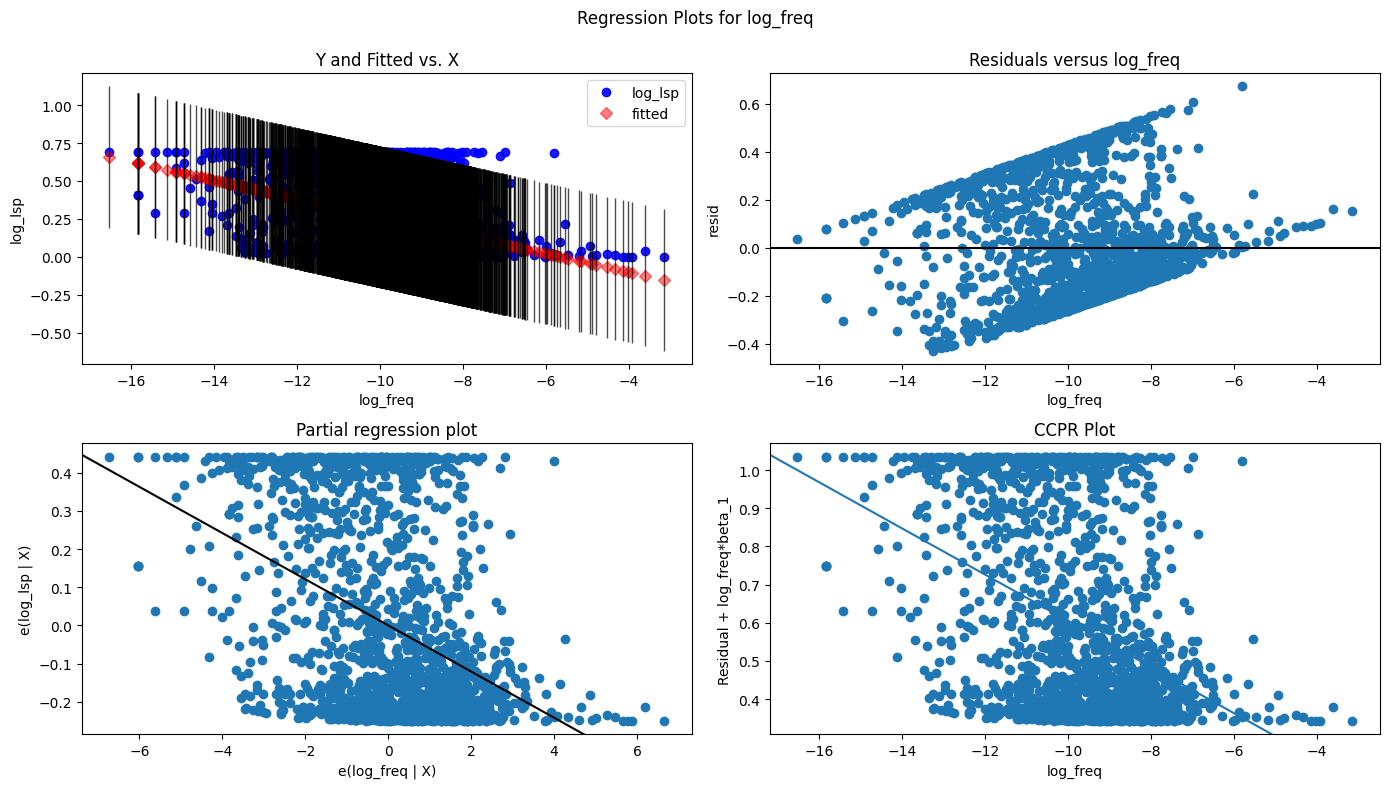

In [19]:
#We could try a linear regression, but I'm not optimistic...linear models assume homoscedasticity and normal distribution of dependent variables.
import statsmodels.api as sm
from statsmodels.formula.api import ols

linear_model = ols('log_lsp ~ log_freq', data=base_freq_lsp_dropped_nas).fit()

print(linear_model.summary())
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(linear_model,'log_freq',fig=fig)
#Indeed, the linear model only explains 16% of the variance, and the residual plots show patterns as log_freq increases - heteroscedasticity is present.

In [20]:
#We therefore fall back on our most robust (but somewhat weaker) test - Spearman's Rank Correlation. 
#We just need two variables measured on an approximately continuous scale, and our null hypothesis is that the correlation coefficient is equal to zero.
#We do not need to log-transform these.
from scipy import stats
res = stats.spearmanr(base_freq_lsp_dropped_nas["frequency"], base_freq_lsp_dropped_nas["learning_signal_precision"])
print(res.statistic)
print(res.pvalue)

-0.3808398004774344
1.2527783669031362e-59


In [21]:
#Repeat this data analysis workflow for the big tokeniser
token_list = []
parent_word = []
counts = []
for row in train_words.itertuples():
    token_ids = big_tok(text_target=row.word)["input_ids"]
    for id in token_ids:
        if (id not in SPECIAL_BIG_TOKENS):
            token_list.append(id)
            parent_word.append(row.word)
            counts.append(row.count)
train_big_tokens = pd.DataFrame(data = {"token":token_list, "parent_word":parent_word, "count":counts})

In [22]:
train_big_tokens_gloss_only = train_big_tokens[train_big_tokens["token"].isin(gloss_big_freq["token"])].sort_values("token").reset_index(drop=True)

In [23]:
train_big_tokens_gloss_only_counts = train_big_tokens_gloss_only.drop(columns=["parent_word"]).groupby(["token"]).sum().reset_index()
train_big_tokens_gloss_only_counts = train_big_tokens_gloss_only_counts.rename(columns={"count":"total_count"}) 

In [24]:
train_big_tokens_gloss_only_counts

,token,total_count
0,2,171
1,10,149002
2,17,52925
3,26,5181
4,27,1
...,...,...
5317,52999,1047
5318,53000,17
5319,53001,664
5320,53004,6


In [25]:
train_big_tokens_parents_sampled_gloss_only = train_big_tokens[train_big_tokens["parent_word"].isin(terms_in_train_ready["fr"])].drop(columns="parent_word").groupby(["token"]).sum().reset_index()
train_big_tokens_parents_sampled_gloss_only = train_big_tokens_parents_sampled_gloss_only.rename(columns = {"count":"term_count"})

In [26]:
train_big_tokens_parents_sampled_gloss_only 

,token,term_count
0,10,2465
1,104,36343
2,293,2
3,394,2
4,433,232
...,...,...
1706,52898,616
1707,52900,86
1708,52912,532
1709,52913,156


In [27]:
big_tok_precision_df = train_big_tokens_parents_sampled_gloss_only.merge(train_big_tokens_gloss_only_counts, how="inner", on="token")
big_tok_precision_df["learning_signal_precision"] = big_tok_precision_df["term_count"] / big_tok_precision_df["total_count"] 
big_tok_precision_df_compact = big_tok_precision_df.drop(columns = ["term_count", "total_count"])

In [28]:
big_freq_lsp = gloss_big_freq.merge(big_tok_precision_df_compact, how="left", on="token").sort_values("token").reset_index(drop=True)

In [29]:
big_freq_lsp = big_freq_lsp[big_freq_lsp["frequency"] > 0]
big_freq_lsp_dropped_nas = big_freq_lsp.dropna().sort_values("frequency", ascending=False).reset_index(drop=True)

In [30]:
big_freq_lsp_dropped_nas["log_freq"] = np.log(big_freq_lsp_dropped_nas["frequency"])
big_freq_lsp_dropped_nas["log_lsp"] = np.log(big_freq_lsp_dropped_nas["learning_signal_precision"] + 1) #Add-one smoothing as LSP can be 0

<Axes: title={'center': 'Log-log plot of LSP against token frequency for opus-big'}, xlabel='Log Token Frequency', ylabel='Log (LSP + 1)'>

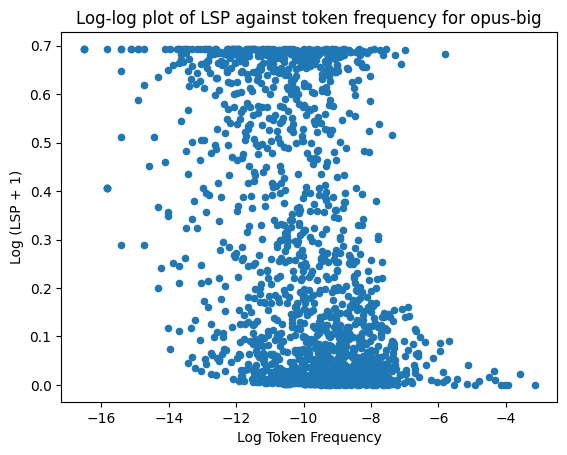

In [47]:
big_freq_lsp_dropped_nas.plot(x="log_freq", y="log_lsp", xlabel = "Log Token Frequency", ylabel = "Log (LSP + 1)", title = "Log-log plot of LSP against token frequency for opus-big", kind = "scatter")

In [32]:
res = stats.spearmanr(big_freq_lsp_dropped_nas["frequency"], big_freq_lsp_dropped_nas["learning_signal_precision"])
print(res.statistic)
print(res.pvalue)

-0.41479621434014585
3.965755180177462e-72


In [33]:
#Collect data on learning signal precision
big_freq_lsp_to_HF = big_freq_lsp_dropped_nas[["token", "learning_signal_precision"]]
big_freq_lsp_to_HF.to_csv("big_lsp.txt", sep = "\t", header = False, index = False)
base_freq_lsp_to_HF = base_freq_lsp_dropped_nas[["token", "learning_signal_precision"]]
base_freq_lsp_to_HF.to_csv("base_lsp.txt", sep = "\t", header = False, index = False)

In [34]:
#Now, we have data on learning signal precision - let's see if it stands up to scrutiny. Might it possibly explain why Ailem did better than the best WCE hyperparameters on our opus-base model?
ailem_terms = load_dataset("ethansimrm/sampled_glossary_0.1_train", split = "train")
ailem_terms_ready = convertToDictFormat(ailem_terms['text'])
wce_terms = load_dataset("ethansimrm/sampled_glossary_0.25_train", split = "train")
wce_terms_ready = convertToDictFormat(wce_terms['text'])

Found cached dataset text (C:/Users/ethan/.cache/huggingface/datasets/ethansimrm___text/ethansimrm--sampled_glossary_0.1_train-4507cd25d8b20eda/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)
Found cached dataset text (C:/Users/ethan/.cache/huggingface/datasets/ethansimrm___text/ethansimrm--sampled_glossary_0.25_train-b7b427cfe8c15d15/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


In [35]:
ailem_tok = base_tok(text_target=ailem_terms_ready["fr"])["input_ids"]
wce_tok = base_tok(text_target=wce_terms_ready["fr"])["input_ids"]

In [36]:
from collections import Counter
def get_token_counts(tokenized_dataset):
    all_tokens = []
    for token_group in tokenized_dataset:
        all_tokens += token_group
    return Counter(all_tokens)

In [37]:
ailem_tok_counts = get_token_counts(ailem_tok)
wce_tok_counts = get_token_counts(wce_tok)

In [38]:
for unwanted_token_id in SPECIAL_BASE_TOKENS:
    del ailem_tok_counts[unwanted_token_id]
    del wce_tok_counts[unwanted_token_id]

In [39]:
ailem_select = base_freq_lsp_dropped_nas[base_freq_lsp_dropped_nas["token"].isin(ailem_tok_counts.keys())]
wce_select = base_freq_lsp_dropped_nas[base_freq_lsp_dropped_nas["token"].isin(wce_tok_counts.keys())]

In [40]:
#Yes, Ailem is a subset of wce_select
merge_df = ailem_select.merge(wce_select, how='left', indicator=True)
merge_df[merge_df["_merge"] != "both"]

,token,frequency,learning_signal_precision,log_freq,log_lsp,_merge


In [41]:
merge_df = ailem_select.merge(wce_select, how='right', indicator=True)
wce_only = merge_df[merge_df["_merge"] != "both"]

In [42]:
#Since we have independent (hence why I hived off the wce_only tokens), unbalanced, and non-normally distributed data, we use a Mann-Whitney U-Test.
#We'd like to see if median frequency or learning signal precision differ significantly between both ailem and those added on to create wce. No transformation needed - this is nonparametric.
#We hypothesise that wce_only tokens occur at a higher frequency than tokens chosen by both methods.
from scipy.stats import mannwhitneyu
x = ailem_select["frequency"]
y = wce_only["frequency"]
res = mannwhitneyu(x, y, alternative="less") #Okay, we do not reject the null hypothesis.
print(res)
#Now, we hypothesise that wce_only tokens have a lower learning signal precision than tokens chosen by both methods. That is, ailem_select tokens have a greater LSP than wce_only tokens.
x = ailem_select["learning_signal_precision"]
y = wce_only["learning_signal_precision"]
res = mannwhitneyu(x, y, alternative="greater") #And there you have it! We reject the null hypothesis and conclude that wce_only tokens possess a significantly lower median LSP.
print(res) 

MannwhitneyuResult(statistic=116973.0, pvalue=0.9999999998200335)
MannwhitneyuResult(statistic=119549.5, pvalue=4.560074428718075e-12)


In [43]:
#Let's see if we can repeat this for the opus-big results. Both performed similarly.
wce_terms_big = load_dataset("ethansimrm/sampled_glossary_0.75_train", split = "train")
wce_terms_big_ready = convertToDictFormat(wce_terms_big['text'])
ailem_tok = big_tok(text_target=ailem_terms_ready["fr"])["input_ids"]
wce_tok = big_tok(text_target=wce_terms_big_ready["fr"])["input_ids"]
ailem_tok_counts = get_token_counts(ailem_tok)
wce_tok_counts = get_token_counts(wce_tok)
for unwanted_token_id in SPECIAL_BIG_TOKENS:
    del ailem_tok_counts[unwanted_token_id]
    del wce_tok_counts[unwanted_token_id]
ailem_select = big_freq_lsp_dropped_nas[big_freq_lsp_dropped_nas["token"].isin(ailem_tok_counts.keys())]
wce_select = big_freq_lsp_dropped_nas[big_freq_lsp_dropped_nas["token"].isin(wce_tok_counts.keys())]

Found cached dataset text (C:/Users/ethan/.cache/huggingface/datasets/ethansimrm___text/ethansimrm--sampled_glossary_0.75_train-75ed1fb2c7269173/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


In [44]:
merge_df = ailem_select.merge(wce_select, how='left', indicator=True)
merge_df[merge_df["_merge"] != "both"]

,token,frequency,learning_signal_precision,log_freq,log_lsp,_merge


In [45]:
merge_df = ailem_select.merge(wce_select, how='right', indicator=True)
wce_only = merge_df[merge_df["_merge"] != "both"]
x = ailem_select["frequency"]
y = wce_only["frequency"]
res = mannwhitneyu(x, y, alternative = "less") #Again, we do not reject the null hypothesis for frequency - 0.75 glossary does not add on terms which are less frequent.
print(res)
x = ailem_select["learning_signal_precision"]
y = wce_only["learning_signal_precision"]
res = mannwhitneyu(x, y, alternative = "greater") #Interestingly, wce_only has terms with significantly lower median LSP than ailem's terms. 
#Might this explain why the performance was similar, rather than better? We can't really say this is strong evidence, either way - we need practical results.
print(res) 

MannwhitneyuResult(statistic=282349.0, pvalue=1.0)
MannwhitneyuResult(statistic=275791.5, pvalue=3.237133376096798e-22)
